# Notebook to plot classification results

## Setup

In [1]:
# imports
from __future__ import annotations
from dataclasses import dataclass
from IPython.display import display
import json
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [2]:
# config
ROOT = Path('/ministorage/adina/classification_eval/folds3_test2')
METRICS_DIR = ROOT / 'cls_metrics/classification' # folder with per-class metrics and confusion matrices
FOLDS_DIR = ROOT # folder with json files containing fold splits
PRETRAINED_COLOR = 'cornflowerblue'
RANDOM_COLOR = 'lightcoral'
PRETRAINED_CMAP = LinearSegmentedColormap.from_list('pretrained_cmap', ['white', PRETRAINED_COLOR])
RANDOM_CMAP = LinearSegmentedColormap.from_list('random_cmap', ['white', RANDOM_COLOR])


## Functions

### Helper functions

In [3]:
# function to parse a tag string (directory name) into structured info
def parse_tag(tag):

    # regex pattern
    TAG_RE = re.compile(
        r"^(?P<init_mode>pretrained|random)_" # pretrained or random init
        r"(?P<split>cvfold\d+|percent_[^_]*)" # cross validation fold or percent split
        r"_ntr(?P<ntr>\d+)_ntest(?P<ntest>\d+)" # dataset pool sizes
        r"_fttr(?P<fttr>\d+)_ftval(?P<ftval>\d+)_seed(?P<seed>\d+)$" # finetune train/val split sizes and seed
    )

    match = TAG_RE.match(tag) # match the tag against the regex
    if not match:
        return None
    
    # convert matched groups to a dict
    d = match.groupdict()

    # convert numeric fields to integers
    for key in ['ntr', 'ntest', 'fttr', 'ftval', 'seed']:
        d[key] = int(d[key])

    # return the parsed dict
    return d


In [4]:
# function to extract a float from a string
def _safe_float_from_kv(cell, key):

    # convert cell to string
    cell_str = str(cell)

    # parse out the value if the string starts with the key
    if cell_str.startswith(key + '='):
        try:
            return float(cell_str.split('=', 1)[1])
        except Exception:
            pass

    # if the key was not found, return NaN
    return float('nan')


In [5]:
# function to read summary metrics (accuracy and macro f1) from a CSV file
def read_overall_metrics(csv_path):

    # read csv into a dataframe
    df = pd.read_csv(csv_path)

    # extract accuracy and macro f1 from the dataframe
    last_row = df.iloc[-1] # last row contains final metrics
    acc = _safe_float_from_kv(last_row.get('precision'), 'ACC') # ACC is in precision column
    macro_f1 = _safe_float_from_kv(last_row.get('recall'), 'MACRO_F1') # MACRO_F1 is in recall column
    support_cell = last_row.get('support', 0)
    support = int(support_cell) if pd.notna(support_cell) else 0

    return acc, macro_f1, support


In [6]:
# function to scan each subdirectory in the metrics folder, parse metadata, and collect results
def collect_runs(metrics_root):

    # list to hold run data
    rows = []

    # iterate over subdirectories in the metrics root
    for sub in sorted(metrics_root.iterdir()):
        if not sub.is_dir():
            continue

        # parse tag and metadata
        tag = sub.name
        meta = parse_tag(tag)
        if not meta:
            continue # skip folders that don't match the expected pattern

        # find metrics csv
        csv_candidates = list(sub.glob(f'per_class_metrics_{tag}.csv')) or list(sub.glob('per_class_metrics_*.csv'))
        if not csv_candidates:
            continue # skip if no metrics csv found

        # read overall metrics
        acc, macro_f1, support = read_overall_metrics(csv_candidates[0])
        rows.append({
            'tag': tag,
            'path': str(sub),
            **meta, # unpack parsed metadata
            'acc': acc,
            'macro_f1': macro_f1,
            'support': support,
        })

    # convert list of rows to a dataframe
    results_df = pd.DataFrame(rows).sort_values(by=['init_mode', 'fttr', 'tag']).reset_index(drop=True)
    return results_df


### Loading and parsing confusion matrix

In [7]:
# function to load confusion matrix csv (where rows and columns are class labels)
def load_cm_csv(path):

    # read the csv into a dataframe
    df = pd.read_csv(path)

    # get columns and rows
    col_labels = list(df.columns[1:]) # class names in header row (exclude first column)
    row_labels = df.iloc[:, 0].tolist() # first column contains row labels

    # reorder rows to match header
    row_index = [row_labels.index(lbl) for lbl in col_labels]

    # extract confusion matrix as a numpy array
    cm = df.iloc[row_index, 1:].to_numpy(dtype=int) # exclude first column (row labels)

    # return column labels (classes) and confusion matrix
    return col_labels, cm


In [8]:
# function to extract fold id and finetune train size (fttr) from filename
def extract_fold_and_fttr(filename):

    # regex patterns
    _CM_FOLD_RE = re.compile(r'cvfold(\d+)')
    _CM_FTTR_RE = re.compile(r'_?fttr(\d+)_?')

    # extract fold id
    match_fold = _CM_FOLD_RE.search(filename)
    match_fttr = _CM_FTTR_RE.search(filename)

    # return fold id and fttr as integers
    return (int(match_fold.group(1)) if match_fold else None, 
            int(match_fttr.group(1)) if match_fttr else None)


In [9]:
# function to detect pretrained vs random init from filename
def detect_init_mode(dirname):

    # get dirname lowercase
    dirname_low = dirname.lower()

    # check for keywords
    if 'pretrained' in dirname_low: return 'pretrained'
    if 'random' in dirname_low: return 'random'

    return 'unknown'


In [10]:
# function to scan confusion matrix directory and load all confusion matrices
def collect_confusion_matrices(cm_root_dir):

    # list to hold cm data
    records = []

    # iterate over subdirectories in the confusion matrix root
    for root, _, files in os.walk(cm_root_dir):
        root_path = Path(root)
        mode = detect_init_mode(root_path.name)

        for file in files:

            # skip if does not match pattern
            if not (file.startswith('confusion_matrix_') and file.endswith('.csv')):
                continue

            # get values
            classes, cm = load_cm_csv(root_path / file)
            fold_id, fttr = extract_fold_and_fttr(file)
            total = cm.sum()
            acc = (np.trace(cm) / total) if total else 0.0 # accuracy from confusion matrix (trace / total)

            # append record
            records.append({
                'mode': mode,
                'train_size': fttr,
                'fold_id': fold_id,
                'classes': tuple(classes),
                'cm': cm,
                'acc': acc,
                'file': str(root_path / file),
            })

    # convert to dataframe and sort
    cm_df = pd.DataFrame(records)
    if not cm_df.empty:
        cm_df = cm_df.sort_values(by=['mode', 'train_size', 'fold_id']).reset_index(drop=True)

    return cm_df


### Confusion matrix plotting utilities

In [11]:
# function to add best fit linear regression line to scatter plot
def _add_best_fit_line(ax, xs, ys, label, color=None, linestyle='-'):

    # calculate best fit line
    if len(xs) >= 2 and np.unique(xs).size >= 2:
        a, b = np.polyfit(xs.astype(float), ys.astype(float), 1) # fit = y = a*x + b
        x_line = np.linspace(xs.min(), xs.max(), 100) # x values for line

        # plot
        ax.plot(x_line, a * x_line + b, color=color, linestyle=linestyle, label=f'{label} best fit')


In [12]:
# create scatter plot of accuracy/f1 vs finetune train size
def plot_metrics_vs_train(df, metric, y_label=None, title=None):

    # ensure metric is valid
    assert metric in ('acc', 'macro_f1'), "Metric must be 'acc' or 'macro_f1'"

    # get ylabels and title
    y_label = y_label or metric.upper()
    title = title or f'Classification: {y_label} vs. finetune train size (fttr)'

    # drop na from metric column
    plot_df = df.dropna(subset=[metric])

    # create figure and axis
    fig, axs = plt.subplots(figsize=(8, 6))

    # plot pretrained vs random groups separately
    for mode, group in plot_df.groupby('init_mode'):
        label = 'Pretrained' if mode == 'pretrained' else 'Random init'
        marker = 'o' if mode == 'pretrained' else 'x'
        color = PRETRAINED_COLOR if mode == 'pretrained' else RANDOM_COLOR
        linestyle = '-' if mode == 'pretrained' else '--'

        # scatter plot
        axs.scatter(
            group['fttr'], 
            group[metric], 
            label=label, 
            color=color,
            marker=marker, 
            alpha=0.8
            )
        _add_best_fit_line(axs, group['fttr'].to_numpy(), group[metric].to_numpy(), label=label, color=color, linestyle=linestyle)

    # set labels and title
    axs.set(title=title, xlabel='Finetune Train Size (fttr)', ylabel=y_label)

    # format and show
    axs.grid(True, alpha=0.3)
    axs.legend()
    plt.tight_layout()
    plt.show()


In [13]:
# function to plot heatmap visualization of a confusion matrix (with optional normalization)
def plot_confusion_matrix_heatmap(cm, classes, title=None, normalize=False, cmap=None):

    # create figure and axis
    fig, axs = plt.subplots(figsize=(5.8, 5.2))

    # normalize rows if requested
    display_cm = cm.astype(float)
    if normalize:
        row_sums = display_cm.sum(axis=1, keepdims=True).astype(float)
        row_sums[row_sums == 0] = 1.0 # prevent division by zero
        display_cm = display_cm / row_sums

    # show matrix as image
    img = axs.imshow(display_cm, aspect='equal', cmap=cmap)
    axs.set_xticks(range(len(classes)))
    axs.set_yticks(range(len(classes)))
    axs.set_xticklabels(classes, rotation=45, ha='right')
    axs.set_yticklabels(classes)
    axs.set(xlabel='Predicted', ylabel='True')
    if title:
        axs.set_title(title)

    # annotate cell values
    for i in range(display_cm.shape[0]):
        for j in range(display_cm.shape[1]):
            val = display_cm[i, j] if normalize else cm[i, j]
            txt = f'{val:.2f}' if normalize else f'{val:d}'
            axs.text(j, i, txt, ha='center', va='center', fontsize=9)

    # format and show
    plt.colorbar(img, ax=axs, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
 

In [14]:
# function to aggregate confusion matrices across folds for each (init_mode, train_size) combination
def aggregate_confusion_matrices(df_cm):

    # list for rows
    rows = []

    # group by init_mode and train_size
    for (mode, train_size), group in df_cm.groupby(['mode', 'train_size'], dropna=False):

        # check that classes are consistent
        classes = list(group.iloc[0]['classes']) if not group.empty else []
        agg = np.sum(group['cm'].to_list(), axis=0) # aggregate confusion matrix by summing
        acc = (np.trace(agg) / agg.sum()) if agg.sum() else 0.0 # accuracy from aggregated cm

        # append row
        rows.append({
            'mode': mode,
            'train_size': train_size,
            'classes': tuple(classes),
            'cm': agg,
            'acc': acc,
            'folds': len(group)
        })

    # convert to dataframe
    return pd.DataFrame(rows).sort_values(by=['mode', 'train_size']).reset_index(drop=True)

In [15]:
# function to show aggregated confusion matrices
def plot_aggregated_confusion_matrices(df_cm, normalize=False, also_individual=False):

    # ensure dataframe is not empty
    if df_cm.empty:
        print("No confusion matrices to display.", flush=True)
        return
    
    # display metrics
    display(df_cm[['mode', 'train_size', 'fold_id', 'acc', 'file']])

    # plot each aggregated confusion matrix
    agg_cm = aggregate_confusion_matrices(df_cm)
    for _, row in agg_cm.iterrows():
        title = f"{row['mode']} | train_size={row['train_size']} | folds={row['folds']} | ACC={row['acc']:.3f}"
        cmap = PRETRAINED_CMAP if row['mode'] == 'pretrained' else RANDOM_CMAP
        plot_confusion_matrix_heatmap(row['cm'], row['classes'], title=title, normalize=normalize, cmap=cmap)

    # optionally plot individual fold confusion matrices as well
    if also_individual:
        for _, row in df_cm.iterrows():
            title = f"{row['mode']} | train_size={row['train_size']} | fold_id={row['fold_id']} | ACC={row['acc']:.3f}"
            cmap = PRETRAINED_CMAP if row['mode'] == 'pretrained' else RANDOM_CMAP
            plot_confusion_matrix_heatmap(row['cm'], row['classes'], title=title, normalize=normalize, cmap=cmap)


In [16]:
# plot overall accuracy vs train size after aggregating results
def plot_agg_acc_vs_train_size(df_cm): 

    # ensure dataframe is not empty
    if df_cm.empty:
        print("No confusion matrices to plot.", flush=True)
        return
    
    # aggregate confusion matrices
    agg_cm = aggregate_confusion_matrices(df_cm)

    # create figure and axis
    fig, axs = plt.subplots(figsize=(6.8, 4.2))

    # plot pretrained vs random groups separately
    for mode, group in agg_cm.groupby('mode'):
        color = PRETRAINED_COLOR if mode == 'pretrained' else RANDOM_COLOR
        axs.plot(group['train_size'], 
                 group['acc'], marker='o' if mode == 'pretrained' else 'x', 
                 label=('Pretrained' if mode=='pretrained' else 'Random'), color=color)

    # set labels and title
    axs.set(xlabel='Finetune train size (fttr)', ylabel='Aggregated accuracy (across folds)', 
            title='Classification accuracy vs. train size (pretrained vs. random init)')
    
    # format and show
    axs.grid(True, linestyle='--', alpha=0.3)
    axs.legend(title='Init')
    plt.tight_layout()
    plt.show()
    

In [17]:
# function to create bar chart comparing train/test sample counts per class for a given fold
def plot_per_class_counts(json_path, fold_id):

    # get metadata, classes, folds
    meta = json.loads(Path(json_path).read_text())
    classes = meta.get('classes', [])
    folds = meta.get('folds', [])

    # error handling for missing folds
    if not folds:
        print(f"No folds found in {json_path}.", flush=True)
        return
    if not (0 <= fold_id < len(folds)):
        print(f"fold_id {fold_id} is out of range (0 to {len(folds)-1}) for {json_path}.", flush=True)
        return
    
    # helper to count patches per class
    def count_patches(paths):
        counts = {c: 0 for c in classes}
        for p in paths:
            cname = Path(p).parent.name
            if cname in counts:
                counts[cname] += 1
        return counts
    
    # get folds and counts
    fold = folds[fold_id]
    train_counts = count_patches(fold.get('train', []))
    test_counts = count_patches(fold.get('test', []))

    # get class indices for bar chart
    x = np.arange(len(classes))

    # width of bars
    w = 0.38

    # create figure and axis
    fig, axs = plt.subplots(figsize=(max(6.5, len(classes)*0.9), 4.2))
    axs.bar(x - w/2, [train_counts[c] for c in classes], width=w, label='Train')
    axs.bar(x + w/2, [test_counts[c] for c in classes], width=w, label='Test')
    axs.set_xticks(x)
    axs.set_xticklabels(classes, rotation=45, ha='right')
    axs.set_ylabel('Num patches')
    axs.set_title(f'Per-class counts | fold {fold_id} | {Path(json_path).name}')
    axs.legend()
    axs.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


## Main

In [18]:
# main function
def main(
        metrics_dir=METRICS_DIR, # directory with per-class metrics and confusion matrices
        folds_dir=FOLDS_DIR, # directory with folds json files
        *,
        do_scalar_plots=True, # plot ACC/F1 vs train size from per_class_metrics
        do_confusion_plots=True, # aggreate and plot confusion matrices
        do_counts_plots=True, # plot per-class train/test counts from folds json
        normalize_cm=False, # row-normalize confusion matrices
        show_individual_cms=False, # also show individual fold confusion matrices
        example_json_name='cls_folds_tr12_test2_rep3.json', # file name of folds json inside folds_dir for counts plot
        example_fold_id=0 # fold id to use for counts plot
):
    
    # 1. scalars from per_class_metrics
    if do_scalar_plots:
        df_runs = collect_runs(metrics_dir)
        print(f'[INFO] Found runs: {len(df_runs)}', flush=True)
        if not df_runs.empty:

            # text summary
            print(df_runs.groupby(['init_mode'])['tag'].count(), flush=True)
            print(df_runs.groupby(['init_mode', 'fttr'])['acc'].agg(['count', 'mean', 'std']).head(12), flush=True)

            # plots
            plot_metrics_vs_train(df_runs, metric='acc', title='Classification Accuracy vs. Finetune Train Size', y_label='Test accuracy')
            plot_metrics_vs_train(df_runs, metric='macro_f1', title='Classification Macro F1 vs. Finetune Train Size', y_label='Test Macro F1')
        else:
            print(f"[WARN] No runs found under {metrics_dir} for scalar plots.", flush=True)

    # 2. confusion matrices
    if do_confusion_plots:
        df_cm = collect_confusion_matrices(metrics_dir)
        if df_cm.empty:
            print(f"[WARN] No confusion matrices found under {metrics_dir}.", flush=True)
        else:
            print(f'[INFO] Found confusion matrices: {len(df_cm)}', flush=True)
            plot_aggregated_confusion_matrices(df_cm, normalize=normalize_cm, also_individual=show_individual_cms)
            plot_agg_acc_vs_train_size(df_cm)

    # 3. per-class counts from folds json
    if do_counts_plots and example_json_name:
        example_json = folds_dir / example_json_name
        if example_json.exists():
            plot_per_class_counts(example_json, example_fold_id)
        else:
            print(f'[WARN] Example folds json not found: {example_json}', flush=True)


[INFO] Found runs: 108
init_mode
pretrained    54
random        54
Name: tag, dtype: int64
                 count      mean       std
init_mode  fttr                           
pretrained 6         3  0.375000  0.125000
           9         3  0.583333  0.072169
           11        3  0.625000  0.216506
           14        3  0.625000  0.216506
           16        3  0.791667  0.072169
           21        3  0.708333  0.072169
           23        3  0.666667  0.072169
           26        3  0.625000  0.125000
           28        3  0.708333  0.072169
           30        3  0.708333  0.072169
           33        3  0.666667  0.072169
           35        3  0.708333  0.144338


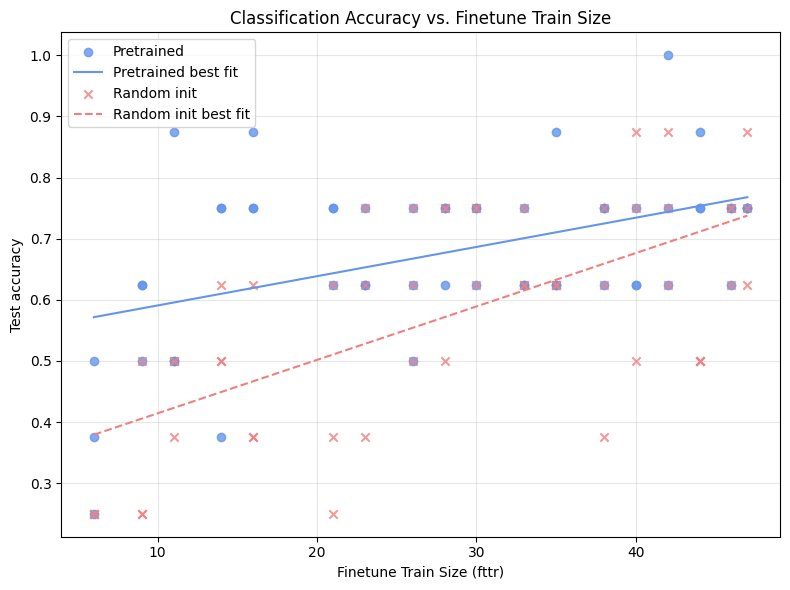

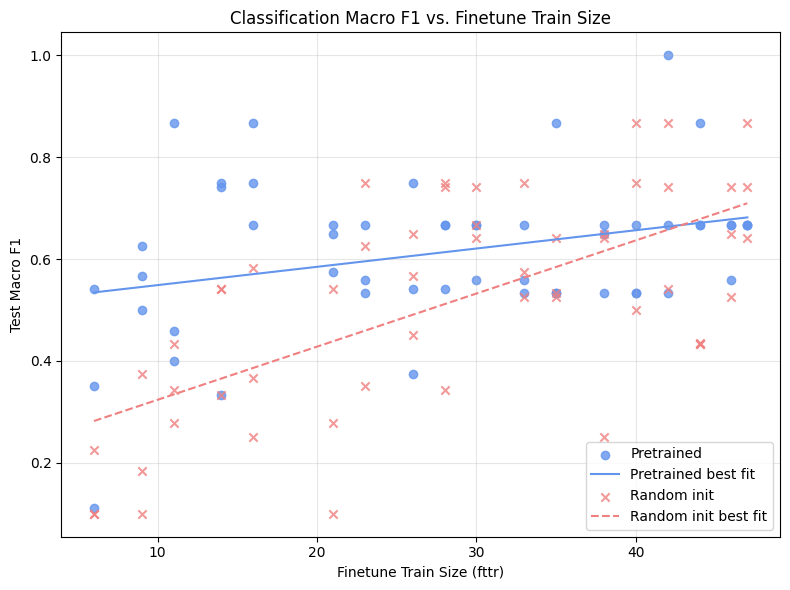

[INFO] Found confusion matrices: 108


,mode,train_size,fold_id,acc,file
0,pretrained,6,0,0.375,/ministorage/adina/classification_eval/folds3_...
1,pretrained,6,1,0.250,/ministorage/adina/classification_eval/folds3_...
2,pretrained,6,2,0.500,/ministorage/adina/classification_eval/folds3_...
3,pretrained,9,0,0.625,/ministorage/adina/classification_eval/folds3_...
4,pretrained,9,1,0.500,/ministorage/adina/classification_eval/folds3_...
...,...,...,...,...,...
103,random,46,1,0.750,/ministorage/adina/classification_eval/folds3_...
104,random,46,2,0.625,/ministorage/adina/classification_eval/folds3_...
105,random,47,0,0.750,/ministorage/adina/classification_eval/folds3_...
106,random,47,1,0.625,/ministorage/adina/classification_eval/folds3_...


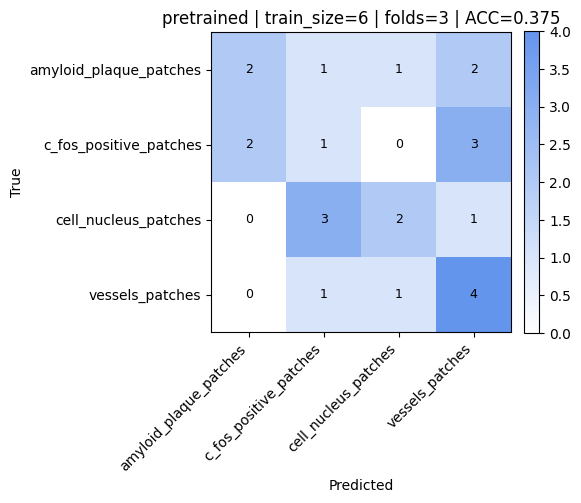

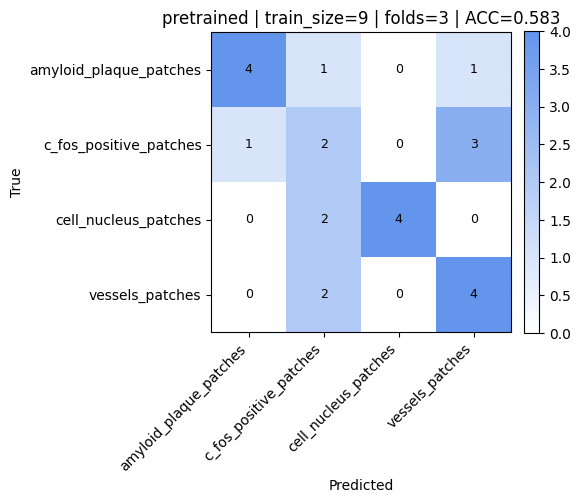

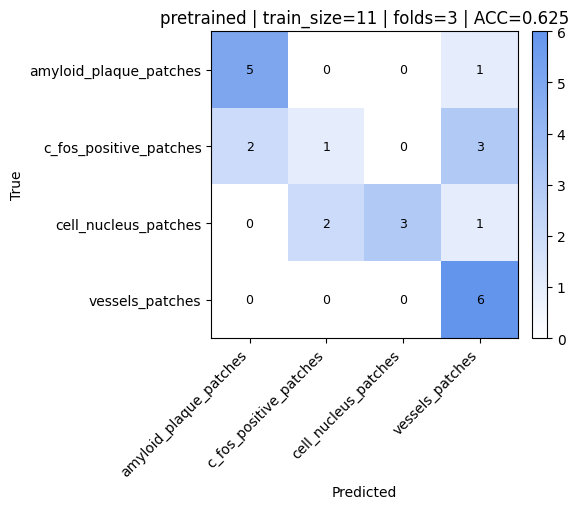

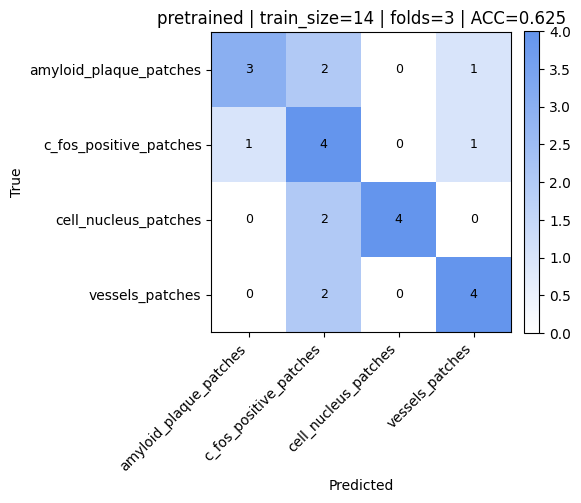

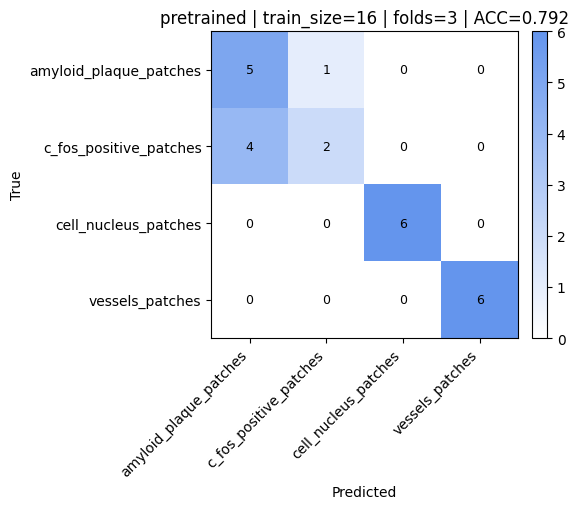

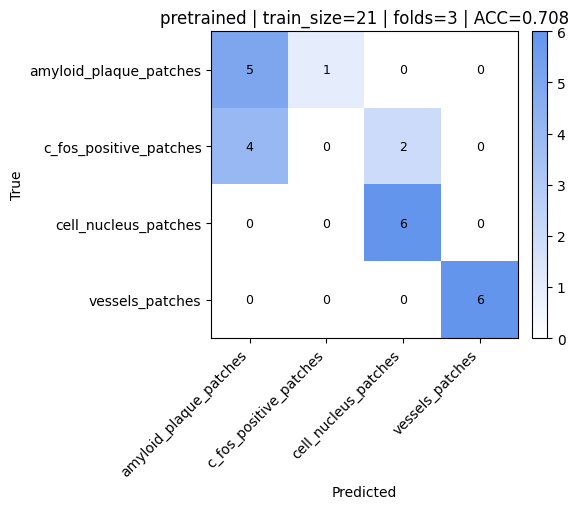

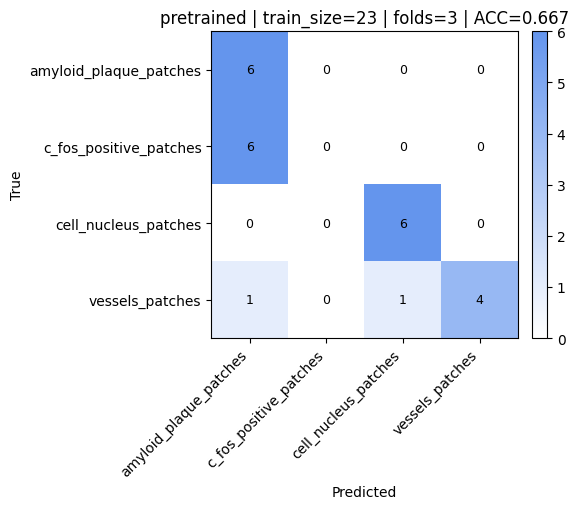

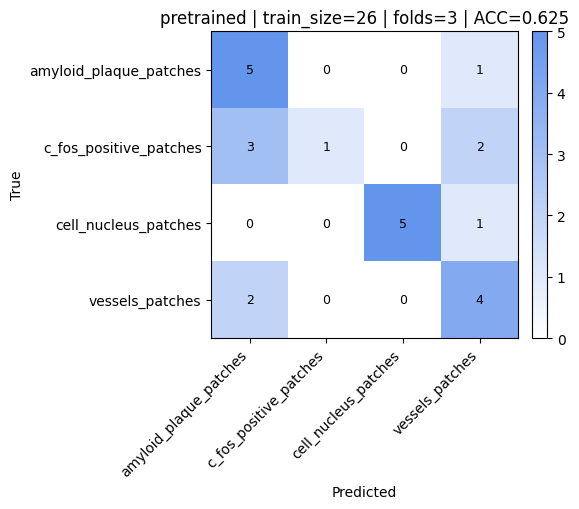

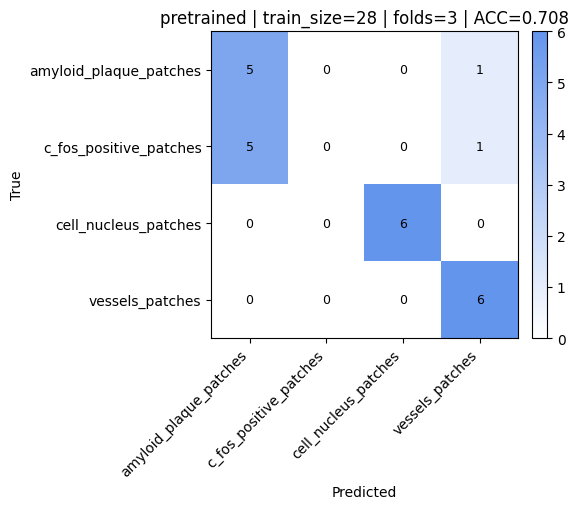

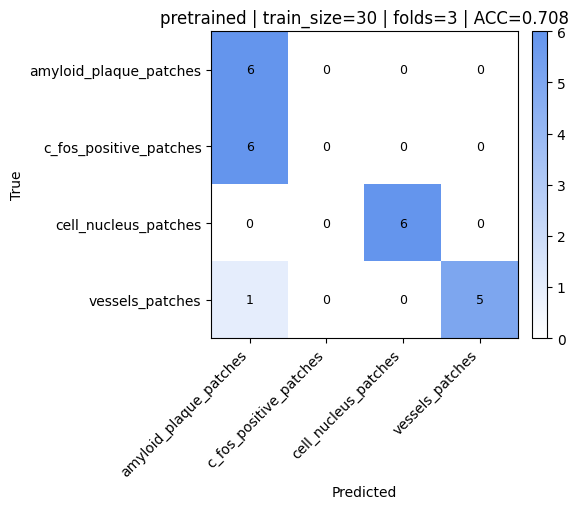

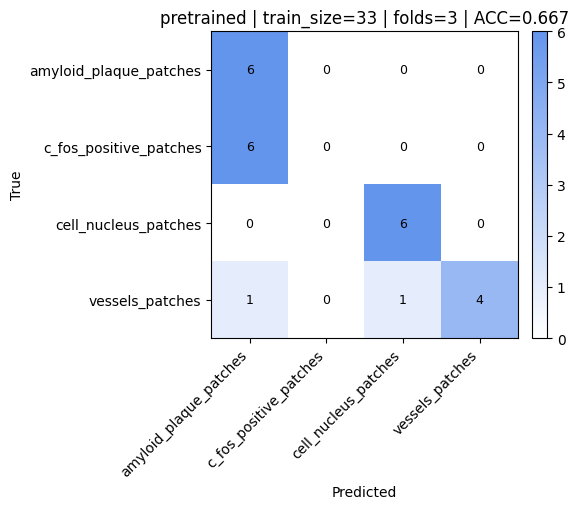

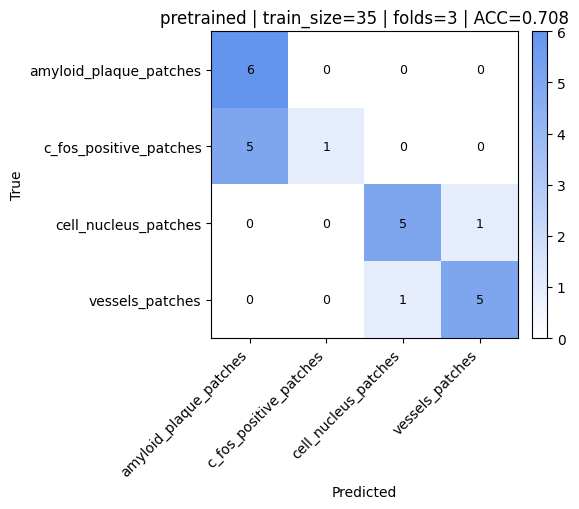

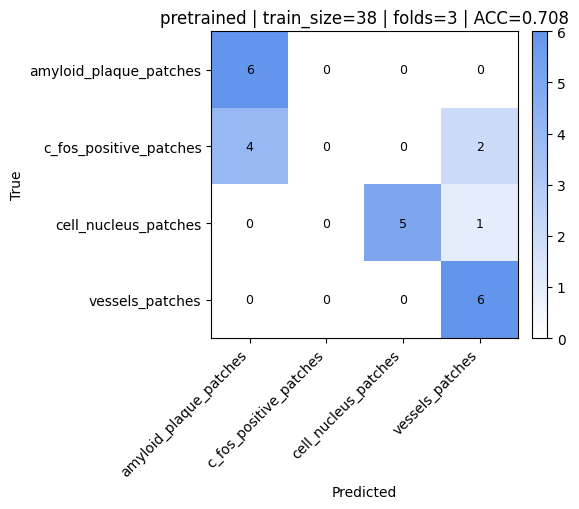

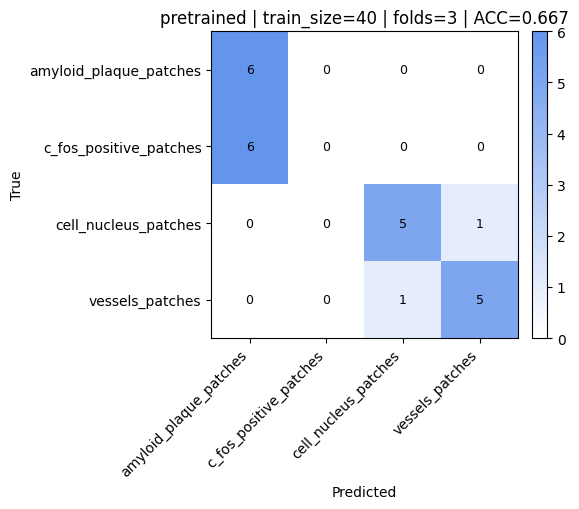

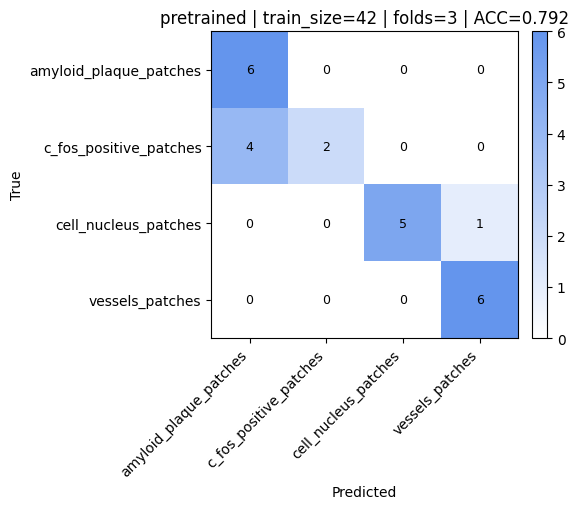

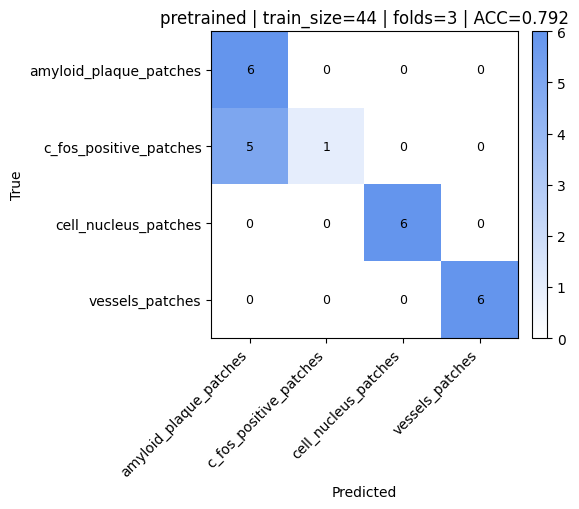

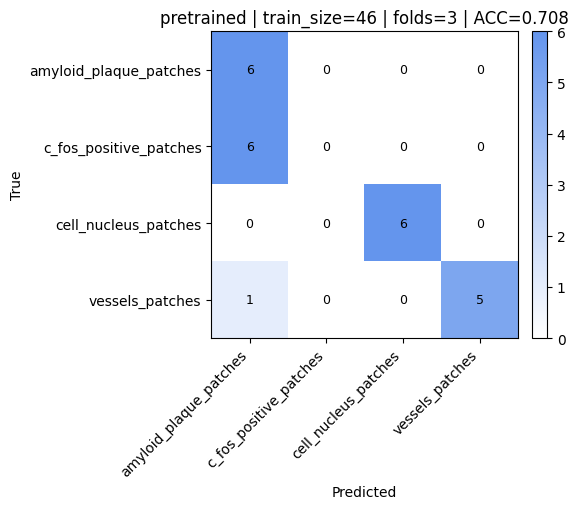

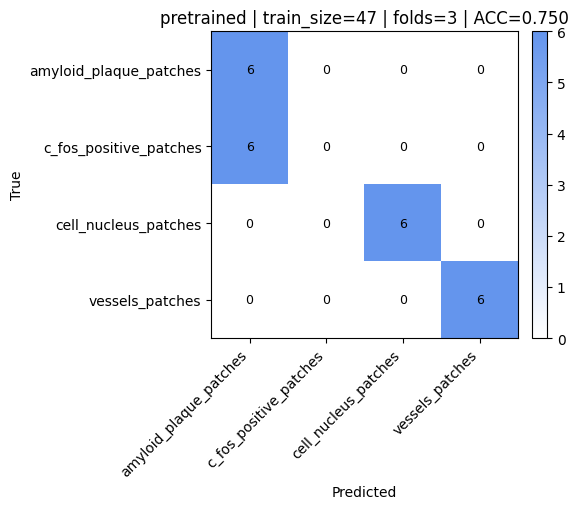

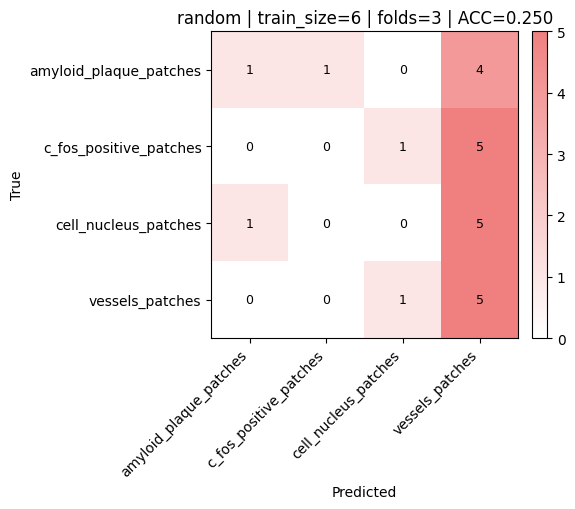

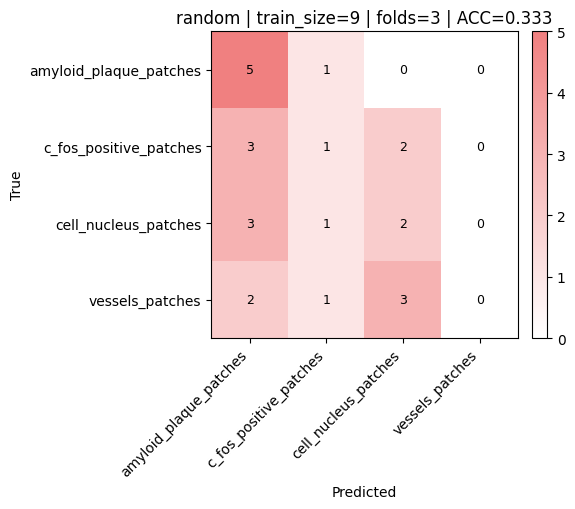

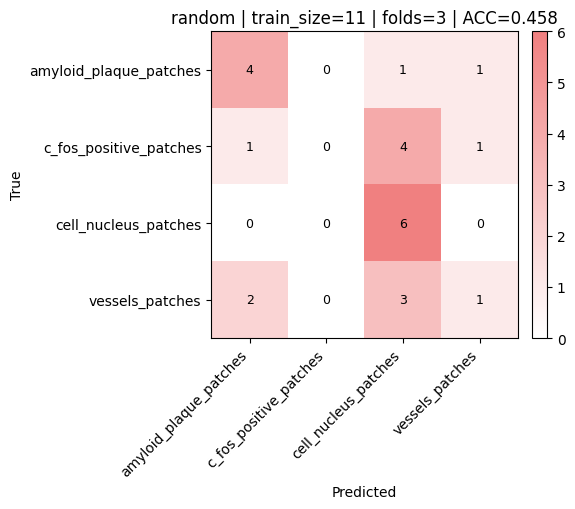

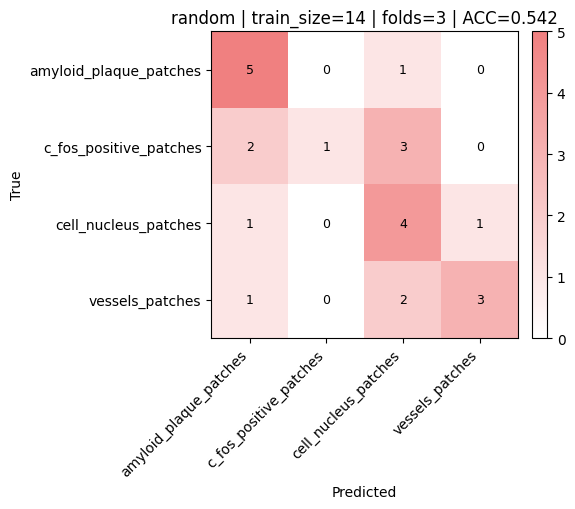

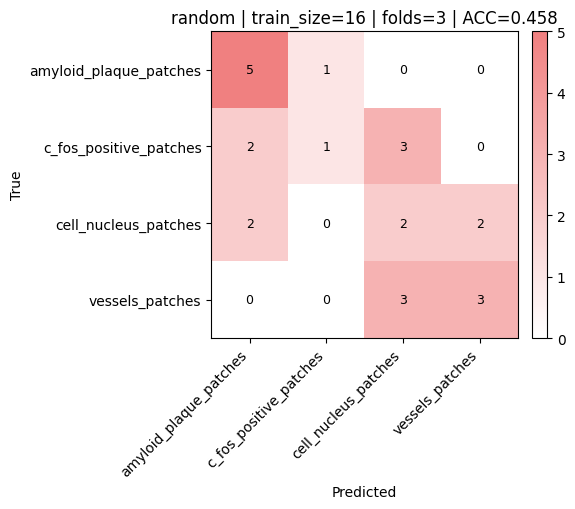

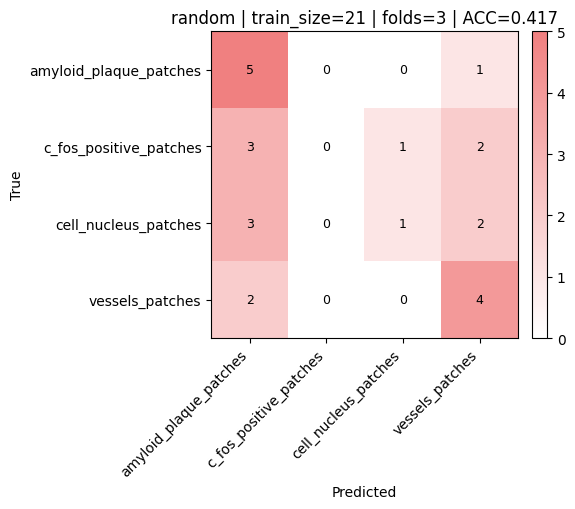

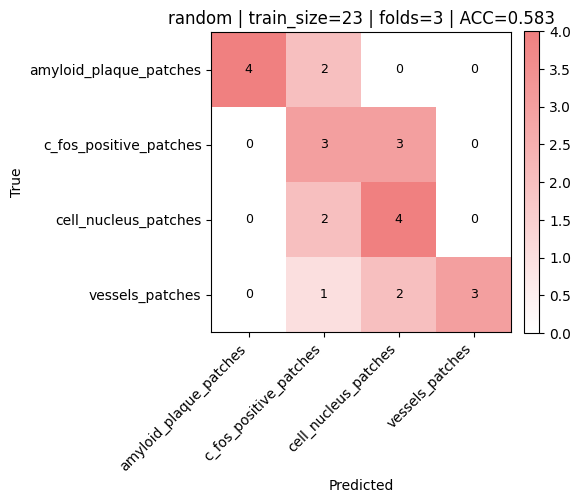

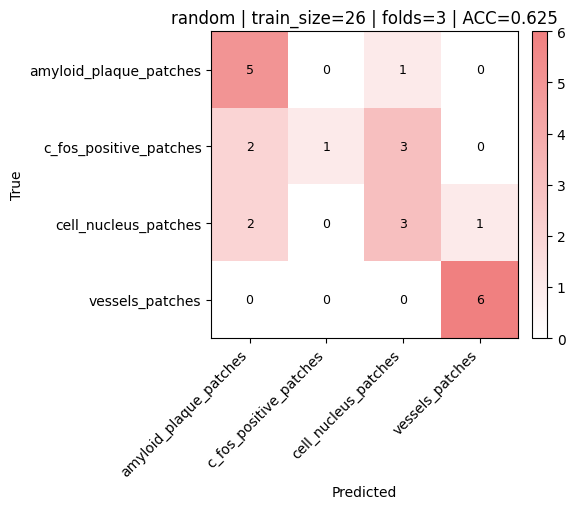

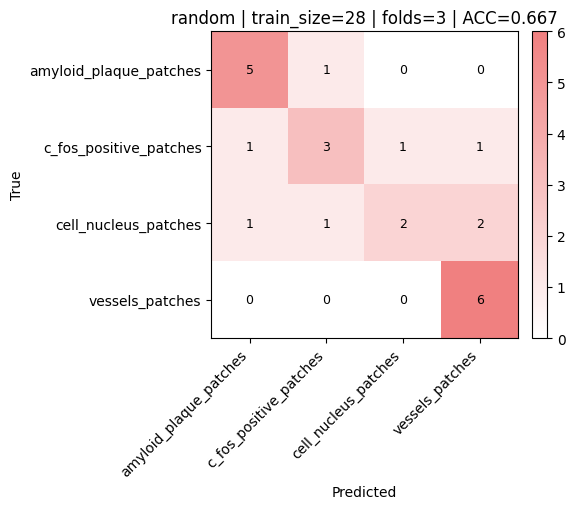

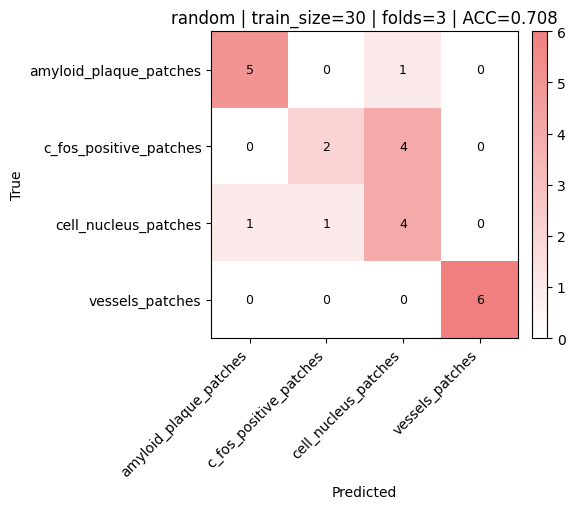

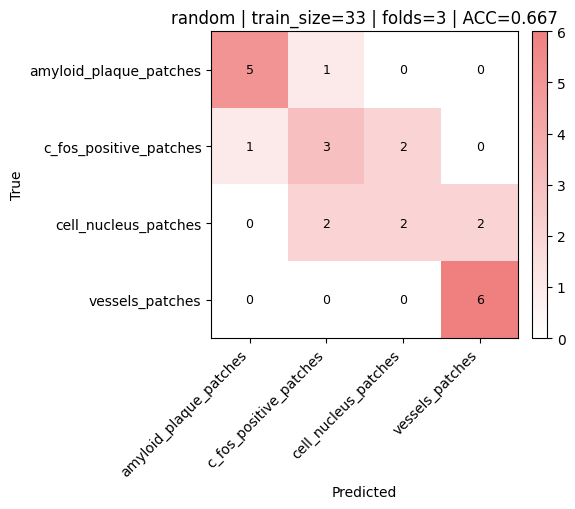

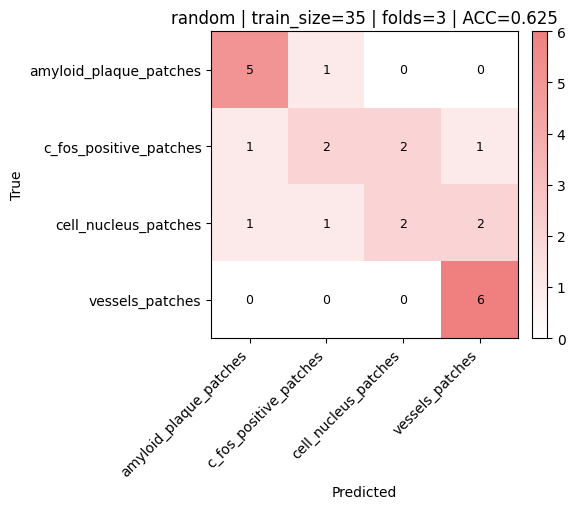

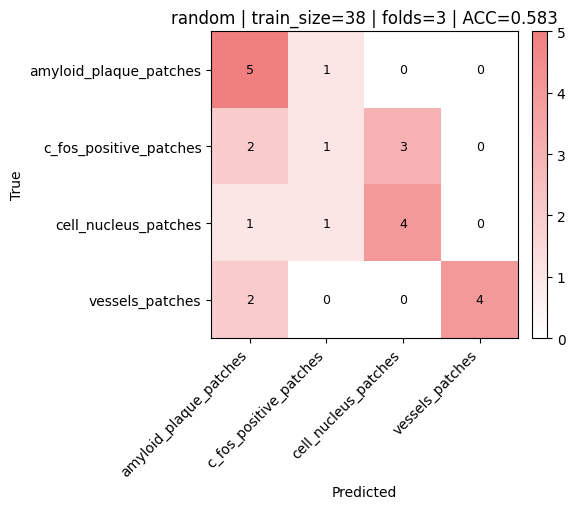

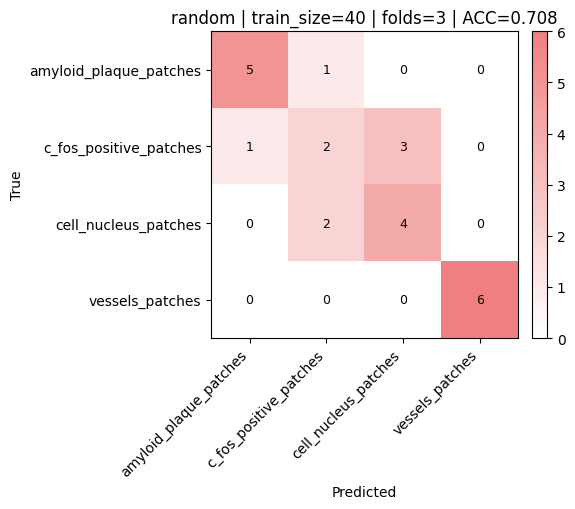

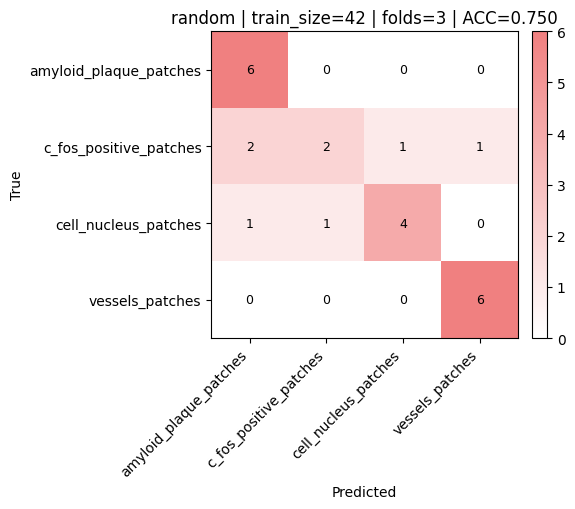

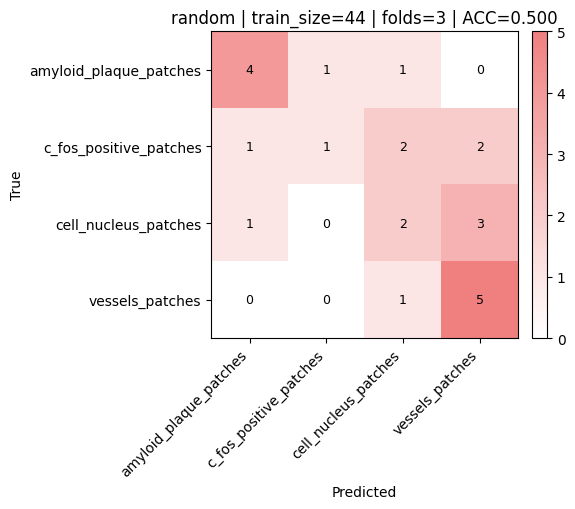

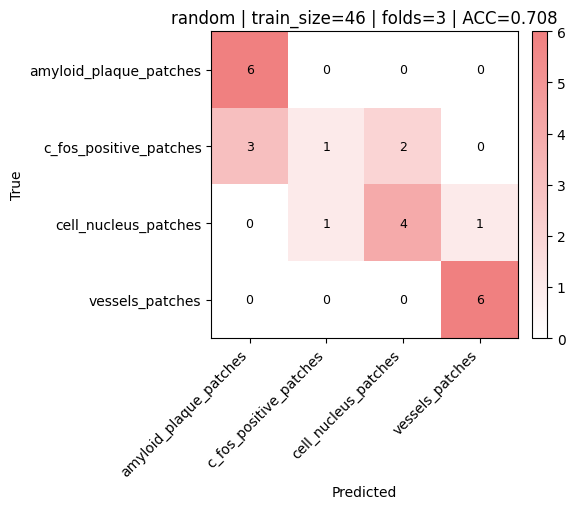

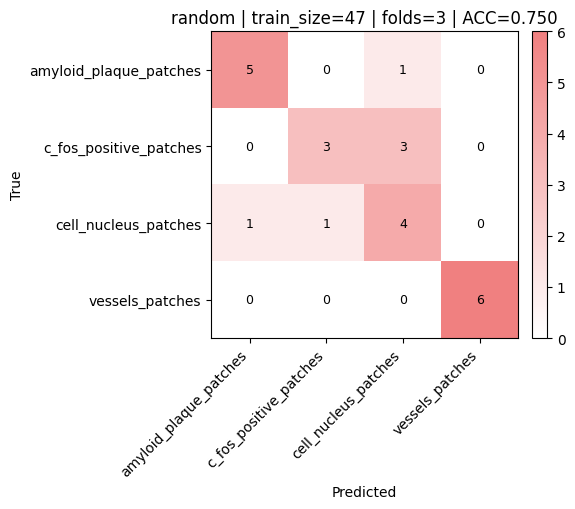

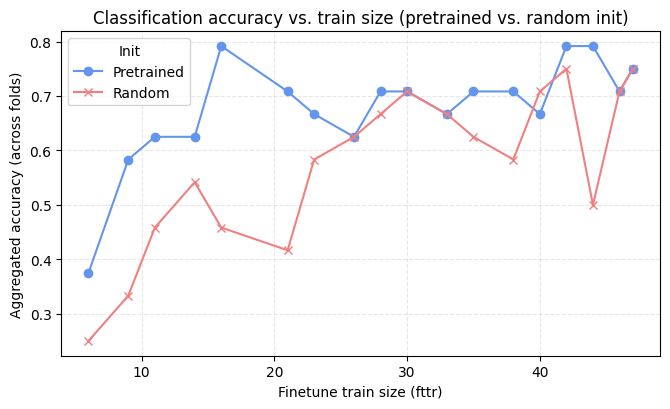

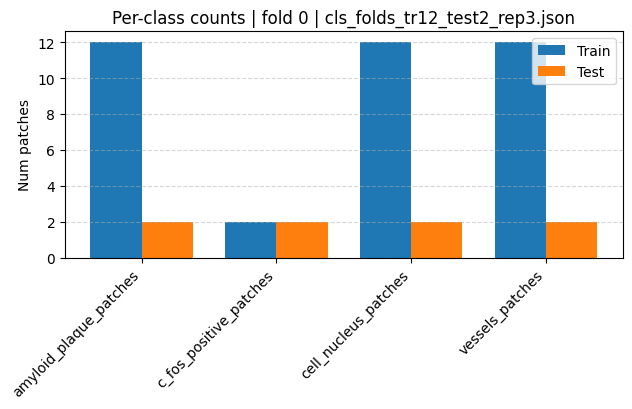

In [19]:
# entry point
if __name__ == '__main__':
    main()
    